In [5]:
import math
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
from scipy import spatial
from scipy import stats
from sklearn.metrics.pairwise import cosine_similarity

plt.rcParams["figure.figsize"] = (20,5)

import doremus_data

Load data.

In [6]:
training_data_folder = '/Users/pasquale/git/recommender/training_data'
emb_folder = '/Users/pasquale/git/music-embeddings'

doremus_data.init(training_data_folder, emb_folder)
vectors, uris, lbs, heads, heads_print = doremus_data.get_embeddings('expression')
pd.DataFrame(heads_print)

,0,1,2,3,4
0,casting,composer,genre,key,composition_date
1,3,3,3,3,1


In [7]:
all_training = doremus_data.all_training('expression')

def training_stats(t):
    num_playlists = len(t['playlists'])
    num_track = [len(p['data']) for p in t['playlists']]
    distinct = len(np.unique(np.concatenate([p['data'] for p in t['playlists']])))
    return num_playlists, np.sum(num_track), np.mean(num_track), distinct

names = [t['name'] for t in all_training]
# for t in all_training:
#     num_playlists, num_track = training_stats(t)
#     print('%s\t\t%d' % (t['name'], num_playlists))
pd.DataFrame([training_stats(t) for t in all_training], index=names, columns='playlists,tracks,tracks per pl, distinct tracks'.split(','))

,playlists,tracks,tracks per pl,distinct tracks
pp_concerts,223,2561,11.484305,2417
itema3_concerts,414,4748,11.468599,4748
web-radio,105,1934,18.419048,1407
spotify_pl,65,1836,28.246154,1425


In [8]:
_l = 5

for t in all_training:
    temp_playlists = []
    for pl in t['playlists']:
        for i in np.arange(len(pl['data']) - _l):
            temp_playlists.append(pl['data'][i:i+_l])
    t['groups'] = [{'name':str(index), 'data': pl} for index, pl in enumerate(temp_playlists)]
    print('%s\t\t%d' % (t['name'], len(temp_playlists)))

pp_concerts		1446
itema3_concerts		2678
web-radio		1409
spotify_pl		1511


Data pre-processing

In [9]:
negVector = -2. * np.ones_like(vectors[0], dtype=np.float32)

def get_embs(x, masked=False):
    # uri to embedding
    v = vectors[np.argwhere(uris == x)]
    if v.size == 0:
        print(x)
        result = np.array(negVector)
    else:
        result = np.array(v[0][0])
    if masked:
        result = np.ma.array(result, mask=result < -1.)
    return result

def get_label(x):
    l =  lbs[np.argwhere(uris == x)]
    return l[0][0] if l.size > 0 else 'none'

In [10]:
np.set_printoptions(2)
def compute_playlist_stats(playlist, to_print=False):
    pl = playlist['data']
    embeddings = np.array([get_embs(xi) for xi in pl])
    emb_len = len(embeddings[0])
    
    ma_embeddings = np.ma.array(embeddings, mask=embeddings < -1.)

    # I do not want to mean dimensions with single values
    mul_values = np.where(np.sum(embeddings >= -1., axis=0) > 1, False, True)
    mul_values = np.repeat([mul_values], len(pl), axis=0)
    ma_embeddings = np.ma.array(ma_embeddings, mask=mul_values)

    _mean = ma_embeddings.mean(axis=0)
    _median = np.ma.median(ma_embeddings, axis=0)
    _min = np.ma.min(ma_embeddings, axis=0)
    _max = np.ma.max(ma_embeddings, axis=0)
    _std = np.ma.std(ma_embeddings, axis=0)
    
    if to_print:
        plt.errorbar(np.arange(len(_mean)), _mean, _std, fmt='ok',
                     ecolor='black', elinewidth=1.5, lw=3, capsize=2)
        plt.errorbar(np.arange(len(_mean)), _mean, [_mean - _min, _max - _mean],
                 fmt='.k', ecolor='gray', elinewidth=0.5, lw=1, capsize=1)

        plt.errorbar(np.arange(len(_mean)), _median, fmt='_g',  lw=1)

        plt.xticks(range(len(heads)), heads, rotation=40)
        plt.show()

    return _mean, _median, _std

Sample playlist

Base: spotify_pl
Playlist: 1023


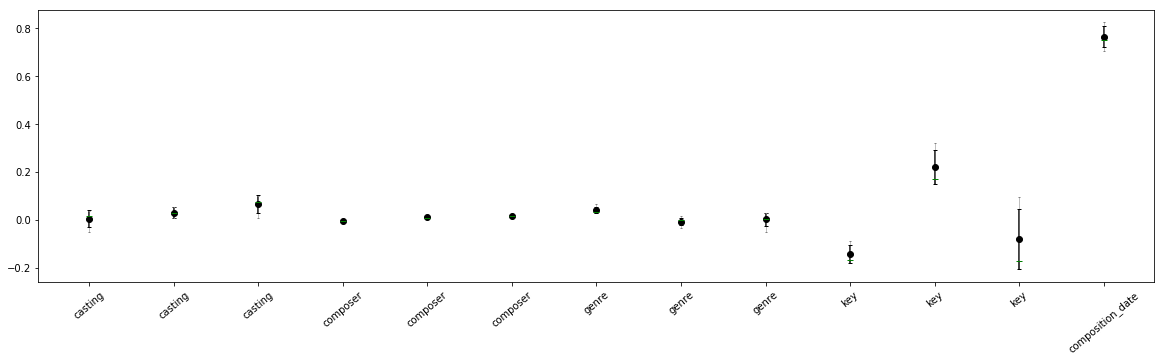

http://overture.doremus.org/expression/ca951b03-f84b-3a7a-aef0-7023af6e8b35
Symhonies
[0.03590903803706169 0.007821599952876568 0.09708871692419052
 -0.006353070493787527 0.008631796576082706 0.015063508413732052
 0.03582938387989998 -0.015889763832092285 0.02758117951452732
 -0.0902123674750328 0.3212423026561737 0.09681284427642822
 0.8038095235824585]
http://overture.doremus.org/expression/41ace8c4-a1b7-3b9d-8339-026e14ed1b54
Symphonies
[-- -- -- -0.003346540266647935 0.012496697716414928 0.012410242110490799
 0.03334466740489006 -0.001616666791960597 0.0029975688084959984
 -0.1695733219385147 0.1698441505432129 -0.1706843227148056
 0.7371428608894348]
http://overture.doremus.org/expression/b53f42ba-9ec1-3e3d-9aa2-1fbff4405093
Requiem
[-0.05006037652492523 0.05418456718325615 0.05414140969514847
 -0.003299245610833168 0.012398893013596535 0.012594932690262794
 0.0664895549416542 0.014949981123209 -0.04941561073064804
 -0.1695733219385147 0.1698441505432129 -0.1706843227148056
 0.705

In [11]:
base = all_training[3]
print('Base: ' + base['name'])
pl = base['groups'][1023]
print('Playlist: ' + pl['name'])

m, md, s = compute_playlist_stats(pl, True)

for d in pl['data']:
    print(d.replace('data', 'overture'))
    print(get_label(d)) 
    print(np.ma.array(get_embs(d), mask=get_embs(d) < -1.))

Standard Deviation among all playlists

In [12]:
population_tot = np.sum([len(pl['data']) for tr in all_training for pl in tr['groups'] ])
std = {}
population = {}
mean = {}
stdw = {} # std within
stdb = {} # std between
                      
for index, tr in enumerate(all_training):
    name = tr['name']
    std[name] = []
    population[name] = []
    mean[name] = []
    for index, pl in enumerate(tr['groups']):
        _mean, _median, _std = compute_playlist_stats(pl, False)
        pop = len(pl['data'])
        population[name].append(pop)
        mean[name].append(_mean)
        ww = (pop - 1) / (population_tot - 1)
        std[name].append((_std**2)*ww)

    stdw[name] = np.ma.sum(std[name], axis=0).filled(0)

In [13]:
weighted_means = [np.ma.mean(mean[name], axis=0)*np.sum(population[name]) for name in mean]

mtot = np.ma.sum(weighted_means, axis=0)
mtot /= population_tot

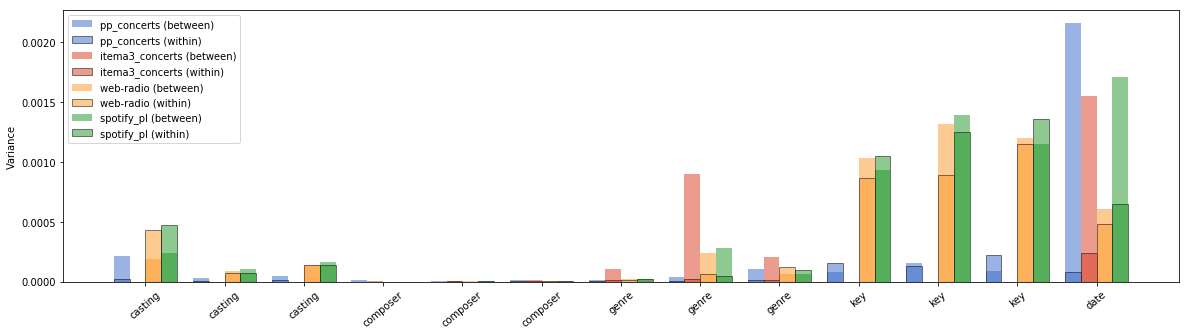

Standard Deviation: mean
[2.33e-04 3.75e-05 7.31e-05 6.52e-07 2.19e-06 4.60e-06 1.36e-05 3.53e-05
 6.20e-05 5.18e-04 5.67e-04 6.83e-04 3.62e-04]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 2.12e-07 1.47e-06 2.89e-06 3.69e-06 8.53e-06
 1.10e-05 0.00e+00 0.00e+00 0.00e+00 8.17e-05]
Standard Deviation between: mean
[1.61e-04 5.63e-05 8.80e-05 5.31e-06 4.64e-06 1.09e-05 3.99e-05 3.65e-04
 1.12e-04 5.11e-04 7.17e-04 6.09e-04 1.51e-03]


In [35]:
fig, ax = plt.subplots(figsize=(20,5))
width = 0.2
pos = np.arange(len(vectors[0]))
colors = ['#3668C9', '#DA3B21', '#FD9827', '#1D9424']


for index, tr in enumerate(all_training):
    name = tr['name']
    
    ww = np.array([pop / (population_tot - 1) for pop in population[name]])
    mg = np.ma.power(np.ma.array(mean[name]).filled(mtot) - mtot, 2)
    stdb[name] = np.ma.sum(mg * ww.reshape(len(ww),1), axis=0)

    plt.bar([p + index * width for p in pos],
        stdb[name],
        width,
        alpha=0.5,
        color=colors[index],
        label=name + ' (between)')
    
    plt.bar([p + index * width for p in pos],
        stdw[name] ,
        width,
        edgecolor='#000000',
        alpha=.5,
        color=colors[index],
        label=name + ' (within)')
    

    
flat_std = [stdw[name] for name in stdw]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

# ax.plot(pos, mstd, '--', label='mean')

heads[-1] = 'date'
plt.xticks(range(len(heads)), heads, rotation=40)
ax.set_ylabel('Variance')
ax.set_xticks([p + 1.5 * width for p in pos])

handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc='upper left')
plt.show()

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))

flat_std_b = [stdb[name] for name in stdb]
mstd_b = np.ma.mean(flat_std_b, axis=0)
print('Standard Deviation between: mean' )
print(np.array(mstd_b))

#### Explaination

When the standard deviation _within_ (black border) is smaller then the standard deviation _between_ (no border), this means that for that dimension the values are more homogeneous _inside_ the group than _outside_.
If this difference in homogeneity inside/outside is important, I can state that this dimension drives the playlist generation.

### Graphs property by property

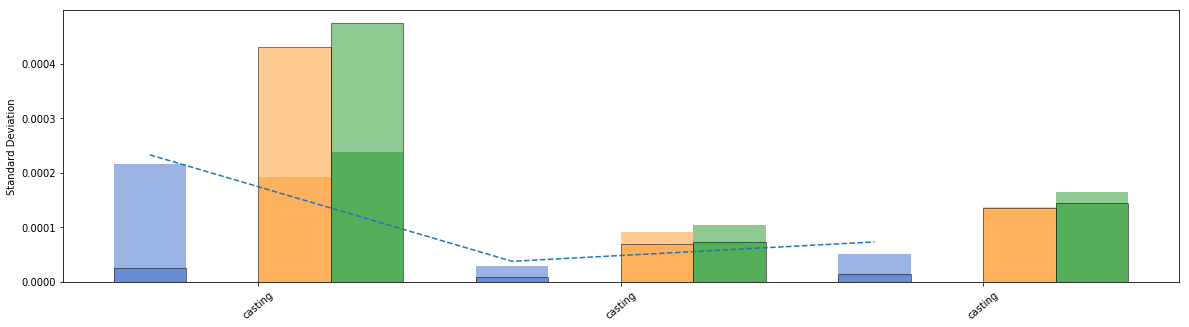

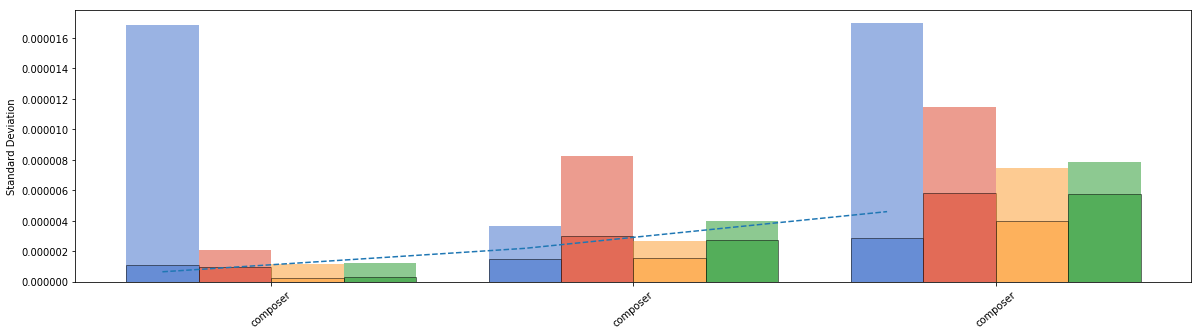

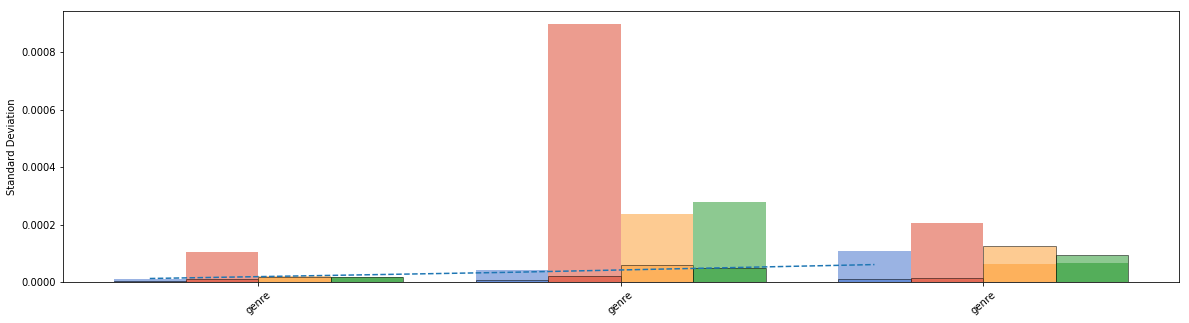

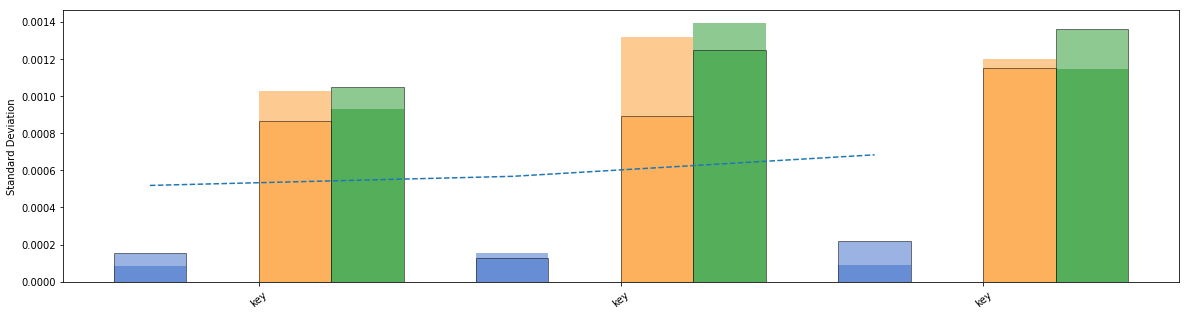

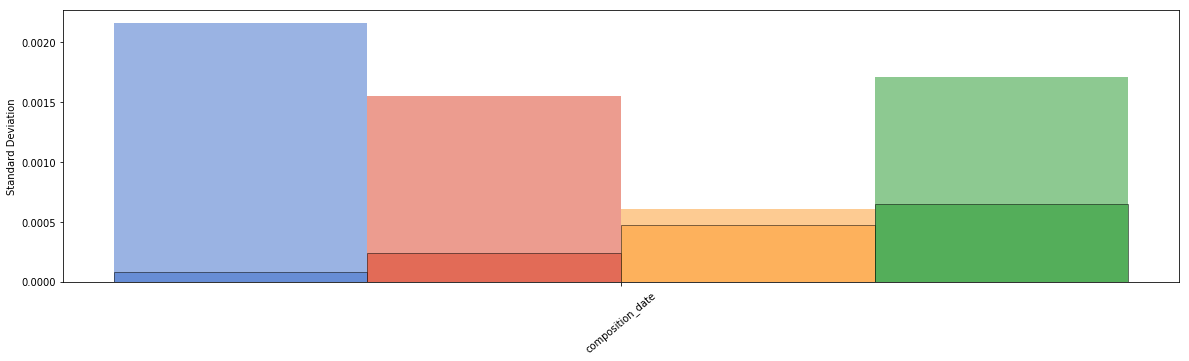

In [15]:
def display_graph(feat):
    pos = np.where(np.array(heads) == feat)[0]
    pos_slide = np.arange(len(pos))
    fig, ax = plt.subplots(figsize=(20,5))

    for index, tr in enumerate(all_training):
        name = tr['name']
        plt.bar([p + index * width for p in pos_slide],
            stdb[name][pos],
            width,
            alpha=0.5,
            color=colors[index],
            label=name + ' (sdt between)')

        plt.bar([p + index * width for p in pos_slide],
            stdw[name][pos] ,
            width,
            alpha=0.5,
            edgecolor='#000000',
            color=colors[index],
            label=name + ' (sdt within)')

    ax.plot(pos_slide, mstd[pos], '--', label='mean')

    plt.xticks(pos_slide, np.array(heads)[pos], rotation=40)
    ax.set_ylabel('Standard Deviation')
    ax.set_xticks([p + 1.5 * width for p in pos_slide])
#     handles, labels = ax.get_legend_handles_labels()
#     ax.legend(handles, labels, loc='upper left')
    plt.show()
    
    
for _f in heads_print[0]:
    display_graph(_f)

For concerts

In [16]:
flat_std = [s for name in ['pp_concerts','itema3_concerts'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)

print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[5.75e-08 2.07e-08 3.08e-08 6.18e-10 1.32e-09 2.55e-09 5.15e-09 9.59e-09
 8.84e-09 1.76e-06 1.45e-06 2.51e-06 1.69e-07]
Standard Deviation: minimum
[0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00 0.00e+00
 0.00e+00 3.32e-08 3.55e-09 3.28e-08 0.00e+00]
Standard Deviation: maximum
[4.34e-07 2.16e-07 2.62e-07 7.64e-09 1.45e-08 1.61e-08 1.66e-07 2.10e-07
 2.68e-07 6.89e-06 5.72e-06 8.69e-06 4.12e-05]


For playlists

In [17]:
flat_std = [s for name in ['web-radio','spotify_pl'] for s in std[name]]
mstd = np.ma.mean(flat_std, axis=0)
sstd = np.ma.std(flat_std, axis=0)
smin = np.ma.min(flat_std, axis=0)
smax = np.ma.max(flat_std, axis=0)


print('Standard Deviation: mean' )
print(np.array(mstd))
print('Standard Deviation: minimum' )
print(np.array(smin))
print('Standard Deviation: maximum' )
print(np.array(smax))

Standard Deviation: mean
[3.11e-07 4.85e-08 9.58e-08 1.72e-10 1.46e-09 3.33e-09 1.33e-08 3.83e-08
 7.59e-08 1.34e-06 1.50e-06 1.76e-06 3.87e-07]
Standard Deviation: minimum
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Standard Deviation: maximum
[1.58e-06 3.18e-07 5.52e-07 1.71e-09 1.02e-08 1.33e-08 1.61e-07 3.38e-07
 6.62e-07 7.71e-06 8.56e-06 8.69e-06 7.55e-06]


# Computing gaps

In [18]:
def get_std_gap(_chosen):
#     return (stdb[_chosen] - stdw[_chosen]) / ((stdw[_chosen] + stdb[_chosen]) / 2 )
    return  stdb[_chosen] / stdw[_chosen]

def display_distances(_chosen):
    better =(stdw[_chosen]<=stdb[_chosen]).tolist()
    distance = get_std_gap(_chosen)

    pd.set_option('precision', 3)
    return pd.DataFrame([better, distance.tolist(), stdw[_chosen].tolist(), stdb[_chosen].tolist()], 
                        index=['homongeneous', '% rate', 'std within', 'std between'], columns=heads)

In [19]:
display_distances('spotify_pl')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
homongeneous,False,True,True,True,True,True,False,True,False,False,True,False,True
% rate,0.5,1.45,1.14,4.15,1.47,1.37,0.999,5.5,0.728,0.886,1.12,0.843,2.65
std within,0.000475,7.24e-05,0.000144,2.9e-07,2.72e-06,5.75e-06,2.05e-05,5.09e-05,9.42e-05,0.00105,0.00125,0.00136,0.000646
std between,0.000237,0.000105,0.000164,1.21e-06,4e-06,7.87e-06,2.05e-05,0.00028,6.86e-05,0.000931,0.00139,0.00115,0.00171


In [20]:
display_distances('web-radio')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
homongeneous,False,True,True,True,True,True,True,True,False,True,True,True,True
% rate,0.444,1.32,1.01,5.41,1.73,1.88,1.16,3.91,0.495,1.19,1.47,1.04,1.26
std within,0.000432,6.88e-05,0.000135,2.12e-07,1.55e-06,3.96e-06,1.81e-05,6.05e-05,0.000127,0.000868,0.000894,0.00115,0.000478
std between,0.000192,9.09e-05,0.000137,1.15e-06,2.68e-06,7.46e-06,2.1e-05,0.000236,6.27e-05,0.00103,0.00132,0.0012,0.000604


In [21]:
display_distances('pp_concerts')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
homongeneous,True,True,True,True,True,True,True,True,True,False,True,False,True
% rate,8.67,3.29,3.82,14.9,2.49,5.88,3.26,5.07,9.85,0.536,1.23,0.42,26.5
std within,2.49e-05,8.95e-06,1.33e-05,1.13e-06,1.47e-06,2.89e-06,3.69e-06,8.53e-06,1.1e-05,0.000155,0.000127,0.000221,8.17e-05
std between,0.000216,2.94e-05,5.09e-05,1.68e-05,3.64e-06,1.7e-05,1.21e-05,4.33e-05,0.000108,8.31e-05,0.000157,9.26e-05,0.00216


In [22]:
display_distances('itema3_concerts')

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
homongeneous,True,True,True,True,True,True,True,True,True,True,True,True,True
% rate,None,None,None,2.14,2.74,1.98,8.68,42.7,12.7,None,None,None,6.37
std within,0,0,0,9.76e-07,3.02e-06,5.79e-06,1.22e-05,2.11e-05,1.63e-05,0,0,0,0.000244
std between,0,0,0,2.09e-06,8.26e-06,1.14e-05,0.000106,0.0009,0.000208,0,0,0,0.00155


2 different tendences between concerts and playlists.

In **concerts** all the dimensions (where they exist) are more homogeneous. This is true in particular for the **casting** (not to be used instead for playlists), and this is reasonable.

The 1st dimension of **composer** is also one to take in account.
In Itema3 this is not visible probably because of bad interlinking of artists.

For the keys, the values are not so relevant and not stable in positiveness.

Always positive (in **bold** the largely ones):
- **composer[0]**
- composer[1,2]
- **genre[2]**
- composition_date
- key[2]
- casting[2]

Positive only in concerts:
- **casting[all]**
- **genre[all]**
- **composition_date**



----
# Tuning the recommender system

In [23]:
def compute_weights(threshold=1.3, fallback = .6, datasets =['spotify_pl']):
    dist = [get_std_gap(_chosen) for _chosen in datasets]
    dist = np.ma.mean(dist, axis=0).filled()

    return np.where(dist > threshold, dist, fallback)

w = compute_weights()
pd.DataFrame([w], columns=heads)

,casting,casting,casting,composer,composer,composer,genre,genre,genre,key,key,key,composition_date
0,0.6,1.45,0.6,4.155,1.467,1.368,0.6,5.505,0.6,0.6,0.6,0.6,2.653


In [24]:
def get_pool_from_datasets(datasets=['web-radio','spotify_pl']):
    all_song = []
    for t in all_training:
        if t['name'] in datasets:
            for pl in t['playlists']:
                 all_song = np.concatenate([all_song, pl['data']])
    all_song = np.unique(all_song)
    print('Pool size: %d' % len(all_song))
    all_song_vec = np.ma.array([get_embs(xi, masked=True) for xi in all_song])
#     all_song_vec = np.ma.array(all_song_vec, mask=all_song_vec < -1.)
    all_song_labels = np.array([get_label(xi) for xi in all_song])
    return all_song, all_song_vec, all_song_labels

In [25]:
def computeSimilarity(seed, target, w):
    b1 = np.where(seed.mask==True)[0]
    b2 = np.where(target.mask==True)[0]
    bad_pos = np.unique(np.concatenate([b1, b2]))

    _seed = np.delete(seed, bad_pos, axis=0)
    _target = np.delete(target, bad_pos, axis=0)
    _w = np.delete(w, bad_pos, axis=0)

    if len(_seed) == 0:
        return 0

    # distance
    d = weightedL2(_seed, _target, _w)

    # how much info I am not finding
    penalty = len([x for x in b2 if x not in b1]) / len(seed)

    # score
    s = (max_distance - d) / max_distance
    return s * (1 - penalty)


def weightedL2(a, b, w=1):
#     return distance.cosine(a,b)
    # https://stackoverflow.com/a/8861999/1218213
    q = a - b
    return np.sqrt((w * q * q).sum())
#     return (w * q * q).sum()


_ones = np.ones(vectors[0].shape)
max_distance = weightedL2(_ones,-_ones, _ones)

In [26]:
def find(seed, n=4, w=None, _print=True, pool=get_pool_from_datasets()):
    global max_distance
    
    _uris =  pool[0]
    _vectors = pool[1]
    _lbs = pool[2]

    
    f_length = len(seed)
    
    _seed = seed
    
    if w is None:
        w = np.ones(len(_seed))
        w = w / w.sum()
    else:
        w = np.array(w)
#         temp = [np.ones(f_length[k]) * w[k] for k in range(len(w))]
#         w = np.array([item for sublist in temp for item in sublist])

    max_distance = weightedL2(np.ones(len(_seed)), np.ones(len(_seed)) * -1, w)

    if _print==True: print('computing scores')
    scores = np.array([[computeSimilarity(_seed, x.astype(float), w) for x in _vectors]])
    full = np.concatenate([_uris.reshape(len(_uris), 1), scores.transpose(), _lbs.reshape(len(_uris), 1)], axis=1)

    # remove the seed from the list
#     full = np.delete(full, pos, 0)

    # sort
    full_sorted = sorted(full, key=lambda _x: float(_x[1]), reverse=True)
    most_similar = full_sorted[:n]
    if _print==True: print('\n'.join('%s %s\n%s' % (f[0], f[1], f[2]) for f in most_similar))

    return [{'uri': _a[0], 'score': float(_a[1])} for _a in most_similar]

Pool size: 2563


In [33]:
find(get_embs('http://data.doremus.org/expression/edfbf89b-1464-32d5-b0e0-3b8db4d80ef1', masked=True))

computing scores
http://data.doremus.org/expression/edfbf89b-1464-32d5-b0e0-3b8db4d80ef1 1.0
Lettre à Elise
http://data.doremus.org/expression/700d8ae4-10b4-323a-91a7-e7721fcc461a 0.9963845712577681
Songs without words
http://data.doremus.org/expression/6b78257e-d9ac-3731-a87d-c69d1a7fce85 0.990682769984646
Rondos. Guitare. La mineur. Op. 2, no 3
http://data.doremus.org/expression/ca3a3163-830f-33f2-94a7-22eda0b9ae7d 0.987704539913521
Toccatas. Piano. Do majeur. Op. 7


[{'score': 1.0,
  'uri': 'http://data.doremus.org/expression/edfbf89b-1464-32d5-b0e0-3b8db4d80ef1'},
 {'score': 0.9963845712577681,
  'uri': 'http://data.doremus.org/expression/700d8ae4-10b4-323a-91a7-e7721fcc461a'},
 {'score': 0.990682769984646,
  'uri': 'http://data.doremus.org/expression/6b78257e-d9ac-3731-a87d-c69d1a7fce85'},
 {'score': 0.987704539913521,
  'uri': 'http://data.doremus.org/expression/ca3a3163-830f-33f2-94a7-22eda0b9ae7d'}]

In [28]:
find(get_embs('http://data.doremus.org/expression/73e749e6-b727-3bfb-bcea-d895c86ec46c', masked=True))

computing scores
http://data.doremus.org/expression/73e749e6-b727-3bfb-bcea-d895c86ec46c 1.0
La Walkyrie
http://data.doremus.org/expression/4edab563-b6d7-38d5-b5b4-8cab4ce81ba6 0.9997358537588898
L'or du Rhin
http://data.doremus.org/expression/e2ed5a11-300b-35d6-bf3e-3044d00c642e 0.9987594389083904
Les Troyens
http://data.doremus.org/expression/784e4581-dd8e-3110-b052-4526f9c0025c 0.9982900558315764
Lohengrin


[{'score': 1.0,
  'uri': 'http://data.doremus.org/expression/73e749e6-b727-3bfb-bcea-d895c86ec46c'},
 {'score': 0.9997358537588898,
  'uri': 'http://data.doremus.org/expression/4edab563-b6d7-38d5-b5b4-8cab4ce81ba6'},
 {'score': 0.9987594389083904,
  'uri': 'http://data.doremus.org/expression/e2ed5a11-300b-35d6-bf3e-3044d00c642e'},
 {'score': 0.9982900558315764,
  'uri': 'http://data.doremus.org/expression/784e4581-dd8e-3110-b052-4526f9c0025c'}]

In [34]:
find(get_embs('http://data.doremus.org/expression/6dd59267-fef0-392d-911f-7abbe676e289', masked=True))

computing scores
http://data.doremus.org/expression/6dd59267-fef0-392d-911f-7abbe676e289 1.0
Les quatre saisons
http://data.doremus.org/expression/f57d703c-276b-3fbf-bcdb-cfdc3e56ea59 0.9985493985051243
12 concertos
http://data.doremus.org/expression/6b5881ec-2df3-368c-9c1d-fc542c955c4e 0.9981870395360538
Concertos. Clavier, flûtes à bec (2), orchestre à cordes, basse continue. Fa majeur. BWV 1057
http://data.doremus.org/expression/d9b19dff-b0eb-3221-b4f1-31fb7e651b91 0.9978019939605289
6 concertos


[{'score': 1.0,
  'uri': 'http://data.doremus.org/expression/6dd59267-fef0-392d-911f-7abbe676e289'},
 {'score': 0.9985493985051243,
  'uri': 'http://data.doremus.org/expression/f57d703c-276b-3fbf-bcdb-cfdc3e56ea59'},
 {'score': 0.9981870395360538,
  'uri': 'http://data.doremus.org/expression/6b5881ec-2df3-368c-9c1d-fc542c955c4e'},
 {'score': 0.9978019939605289,
  'uri': 'http://data.doremus.org/expression/d9b19dff-b0eb-3221-b4f1-31fb7e651b91'}]

In [46]:
def recommend_compare(playlist, w, pos=-1, num_candidates=[100, 200, 500],
                      verbose=True, pool=get_pool_from_datasets(), overture=True):
    pl_data = playlist['data']
    pl_population = len(pl_data)
    if verbose: print('%d items | %s' % (pl_population, playlist['name'].split('/')[-1]))
    
    _replcm = 'overture.' if overture else 'data.'
    
    if pos < 0:
        pos = random.randrange(pl_population)
   
    chosen = pl_data[pos]
    targets = pl_data
#     [max(pos-7,0):min(pos+7, len(pl_data))]
    targets_pop = len(targets)
#     print(max(pos-5,0))
#     print(min(pos+5, len(pl_data)))
#     print(targets_pop)

    if verbose: 
        print('seed: %d) %s' % (pos, get_label(chosen)))
        print('\t '+ chosen.replace('data.', _replcm))

    
    first = get_embs(chosen, masked=True)

    candidates = find(first, n=np.max(num_candidates), _print=False, pool=pool )
    candidates_2 = find(first, n=np.max(num_candidates), _print=False, w = w, pool=pool )
    
    results = np.zeros((len(num_candidates), 3))
    
    for qi, q in enumerate(num_candidates):
        trues_flat = 0
        for index, c in enumerate(candidates[:q]):
            if c['uri'] == chosen: continue
            if c['uri'] in targets: trues_flat+=1
#             if verbose:
#                 _sig = '  X  ' if c['uri'] in targets else '   '
#                 print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
#                 print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
        #     display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))


        trues = 0
        for index, c in enumerate(candidates_2[:q]):
            if c['uri'] == chosen: continue
            if c['uri'] in targets: trues+=1
#             if verbose:
#                 _sig = '  X  ' if c['uri'] in pl_data else '   '
#                 print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
#                 print('\t\t\t\t'+ c['uri'].replace('data.', 'overture.'))
#                 # display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

        if verbose: print('%d | flat %d | weighted %d | diff %d' % (q, trues_flat, trues, trues-trues_flat))
        results[qi] = [trues / targets_pop, trues_flat / targets_pop, (trues-trues_flat) / targets_pop]
    return results

Pool size: 2563


In [47]:
pl = all_training[3]['playlists'][55]
recommend_compare(pl, w, 9)

47 items | 37i9dQZF1DXaSipEWiHbyL.Classical World: USA.expression.txt
seed: 9) Electric counterpoint
	 http://overture.doremus.org/expression/358ec945-c4a0-381e-921e-8fba13266007
100 | flat 11 | weighted 14 | diff 3
200 | flat 16 | weighted 18 | diff 2
500 | flat 24 | weighted 28 | diff 4


array([[0.3 , 0.23, 0.06],
       [0.38, 0.34, 0.04],
       [0.6 , 0.51, 0.09]])

### Computation on all playlists

In [48]:
out_path = './out'

def ensure_dir(file_path):
    directory = os.path.dirname(file_path)
    if not os.path.exists(directory):
        os.makedirs(directory)
    return file_path

from tqdm import tqdm_notebook as tqdm

In [49]:
def test_recommendation(pool, playlist, pos=-1, mode='random', w=None, name='', verbose=0, overture=False, write=False):
    pl_data = playlist['data']
    pl_population = len(pl_data)
    pl_name = playlist['name'].split('/')[-1].replace('.json', '')
    
    _replcm = 'overture.' if overture else 'data.'

    if pos < 0:
        pos = random.randrange(pl_population)
    chosen = pl_data[pos]
    pl_data = np.delete(pl_data, pos, axis=0)

    if verbose > 0: 
        print('%d items | %s' % (pl_population, pl_name))
        print('seed: %d) %s' % (pos, get_label(chosen)))
        print('\t '+ chosen.replace('data.', _replcm))

    
    first = get_embs(chosen, masked=True)
    num_candidates=[100, 200, 500]
    max_candidates = np.max(num_candidates)

    if mode == 'flat':
        candidates = find(first, n=max_candidates, _print=False, pool=pool)
    elif mode == 'weighted':
        candidates = find(first, n=max_candidates, _print=False, w = w, pool=pool)
    else : # random
        candidates =  list(map(lambda x: {'uri': x, 'score': 0}, random.sample(pool[0].tolist(), 500)))

    results = np.zeros(len(num_candidates))
    candidates_uri =  list(map(lambda x: x['uri'], candidates))

    for qi, q in enumerate(num_candidates):
        trues = len(set(candidates_uri[:q]).intersection(set(pl_data)))
        
        if verbose > 0:
            print('%d | positive %d | population %d' % (q, trues, pl_population))
        results[qi] = trues

    if verbose > 1:
        for index, c in enumerate(candidates[:max_candidates]):
            _sig = '  X  ' if c['uri'] in pl_data else '   '
            print('%d \t %.5f'% (index, c['score']) + '\t' + _sig + '\t' + get_label(c['uri']))
            print('\t\t\t\t'+ c['uri'].replace('data.', _replcm))
            # display(pd.DataFrame(np.ma.array( candidates[c]).reshape(1, 13)))

    if write:
        to_write =[';'.join([
                    str(index),
                    str(c['score']), 
                    '1' if c['uri'] in pl_data else '0',
                    get_label(c['uri']),
                    c['uri'].replace('[;\n"]', ' ')
                   ])
            for index, c in enumerate(candidates[:max_candidates])]

        filename = pl_name + '.' + str(pos) + '.csv'
        with open(ensure_dir(os.path.join(out_path, 'detail', name, filename)), 'w') as file:
            file.write('index;score;predicted;label;uri\n')
            file.write('\n'.join(to_write))

    return results

In [50]:
def run_for_dataset(id_dataset, pool, mode='random', w=None, name=''):
    with open(ensure_dir(os.path.join(out_path, 'summary', name + '.csv')), 'w') as file:
        file.write('index;playlist;population;predicted100;predicted200;predicted500\n')
        testset = all_training[id_dataset]['playlists']
        
        pbar = tqdm(total=len(testset))

        for index, pl in enumerate(testset):
            population = len(pl['data'])
            pl_name = pl['name'].split('/')[-1].replace('.json', '').replace('"','')

            results = [test_recommendation(pool=pool, playlist=pl, pos=pos,  
                                    mode=mode, w=w, write=False, name=name)
                       for pos, work in enumerate(pl['data'])]
            results = np.mean(results,axis=0)
            
            file.write(';'.join([str(index), pl_name, str(population), 
                                 str(results[0]), str(results[1]), str(results[2])]))
            file.write('\n')
            pbar.update(1)
    pbar.close()

In [423]:
# test_recommendation(pp_pool, playlist=all_training[0]['playlists'][4], mode='weighted', name='pp.w5-06', w=_wpp, verbose=2 )

In [363]:
# itema3_pool = get_pool_from_datasets(['itema3_concerts'])

In [369]:
run_for_dataset(1, itema3_pool, mode='random', name='itema3.rand')

In [371]:
run_for_dataset(1, itema3_pool, mode='flat', name='itema3.flat')

In [378]:
_wi3 = compute_weights(threshold=5, datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w5-06', w= _wi3)

In [437]:
_wi3 = compute_weights(threshold=8, datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w8-06', w= _wi3)

In [444]:
_wi3 = compute_weights(threshold=10, datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w10-06', w= _wi3)

In [445]:
_wi3 = compute_weights(threshold=8, fallback=1., datasets=['itema3_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.w8-1', w= _wi3)

In [ ]:
_wi3 = compute_weights(threshold=5, datasets=['itema3_concerts', 'pp_concerts'])
run_for_dataset(1, itema3_pool, mode='weighted', name='itema3.wp5-06', w= _wi3)

In [ ]:
pp_pool = get_pool_from_datasets(['pp_concerts'])

In [ ]:
run_for_dataset(0, pp_pool, mode='random', name='pp.rand')

In [ ]:
run_for_dataset(0, pp_pool, mode='flat', name='pp.flat')

In [ ]:
_wpp = compute_weights(threshold=5, datasets=['pp_concerts'])
# pd.DataFrame([_wpp], columns=heads)

In [ ]:
run_for_dataset(0, pp_pool, mode='weighted', name='pp.w5-06', w=_wpp)

In [ ]:
spo_pool = get_pool_from_datasets(['spotify_pl'])

In [ ]:
run_for_dataset(3, spo_pool, mode='random', name='spotify.rand')

In [ ]:
run_for_dataset(3, spo_pool, mode='flat', name='spotify.flat')

In [ ]:
_wspo = compute_weights(threshold=1.3, datasets=['spotify_pl'])
run_for_dataset(3, spo_pool, mode='weighted', name='spotify.w13-06', w=_wspo)

In [54]:
radio_pool = get_pool_from_datasets(['web-radio'])

Pool size: 1407


In [ ]:
run_for_dataset(2, radio_pool, mode='random', name='web-radio.rand')

In [ ]:
run_for_dataset(2, radio_pool, mode='flat', name='web-radio.flat')

In [ ]:
_wradio = compute_weights(threshold=1.4, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w14-06', w=_wradio)

In [59]:
_wradio = compute_weights(threshold=1.4, datasets=['web-radio'])
_wradio[-1] *= 2
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.wd14-06', w=_wradio)

In [56]:
_wradio = compute_weights(threshold=1.5, datasets=['web-radio'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.w15-06', w=_wradio)

In [ ]:
_wradio = compute_weights(threshold=1.4, datasets=['web-radio', 'spotify_pl'])
run_for_dataset(2, radio_pool, mode='weighted', name='web-radio.ws14-06', w=_wradio)

In [61]:
summary_path = os.path.join(out_path, 'summary')
columns = ['name', 'r100', 'r200', 'r500']
summary = pd.DataFrame(columns=columns)

for index, filename in enumerate(sorted(os.listdir(summary_path))):
    table = pd.read_csv(os.path.join(summary_path,filename), sep=';')
    table['r100'] = table.apply(lambda row: row['predicted100']/row['population'], axis=1)
    table['r200'] = table.apply(lambda row: row['predicted200']/row['population'], axis=1)
    table['r500'] = table.apply(lambda row: row['predicted500']/row['population'], axis=1)
    r100 = table['r100'].mean()
    r200 = table['r200'].mean()
    r500 = table['r500'].mean()
    summary.loc[index] = [filename, r100, r200, r500]
summary

,name,r100,r200,r500
0,itema3.flat.csv,0.363,0.423,0.506
1,itema3.rand.csv,0.018,0.039,0.095
2,itema3.w10-06.csv,0.367,0.417,0.491
3,itema3.w5-06.csv,0.370,0.425,0.502
4,itema3.w8-06.csv,0.381,0.431,0.498
5,itema3.w8-1.csv,0.378,0.430,0.500
6,itema3.wp5-06.csv,0.362,0.422,0.498
7,pp.flat.csv,0.475,0.536,0.634
8,pp.rand.csv,0.037,0.076,0.188
9,pp.w5-06.csv,0.479,0.546,0.640


In [ ]:
rc = {}
quantities = [100, 200, 500]
_headers = np.array([['weighted %d' % q, 'flat %d' % q, 'diff %d' % q] for q in quantities]).flatten()

def compute_for_dataset(dataset, w):
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for pl, idxp in log_progress(playlists, name=dataset['name']):
        rcomp = [recommend_compare(pl, w, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        current[idxp] = np.mean(rcomp, axis=0)
    return current

In [ ]:
def evaluate(w, toPrint=False):
    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset, w)
    
    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    if toPrint:    
        return pd.DataFrame(
            _data,
            index = [ds for ds in rc],
            columns = _headers
        )
    else:
        return _data

In [ ]:
evaluate(w, True)

I try with different values

In [ ]:
def try_with(threshold):
    w = compute_weights(threshold=threshold)

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [ ]:
from IPython.display import display, HTML

for dataset in all_training[2:4]:
    playlists = dataset['playlists']
    for pl in playlists:
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        missing = [len(np.where(get_embs(item) < -1.)[0]) for item in pl['data']]
        _counts = sorted(pd.Series(missing).value_counts().reset_index().values.tolist())
        _pt = ['%d (%d)' % (item[0], item[1]) for item in _counts]
        print('\t\t\t'+'\t'.join(_pt))

In [ ]:
try_with(1.4)

In [ ]:
try_with(1.5)

In [ ]:
try_with(2.)

In [ ]:
try_with(1.2)

In [ ]:
try_with(1.1)

In [ ]:
try_with(1.)

In [ ]:
for dataset in all_training[3:4]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, w, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

In [ ]:
0.00030769230769230765 | 0.007507692307692307 | 0.013246153846153847

In [ ]:
for dataset in all_training[2:3]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, w, elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

In [ ]:
0.00006349206349206348 | 0.0015492063492063492 | 0.0027333333333333333

In [ ]:
for dataset in all_training[3:4]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.4), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

In [ ]:
for dataset in all_training[2:3]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.4), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

In [ ]:
for dataset in all_training[3:4]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.5), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

In [ ]:
for dataset in all_training[2:3]:
    playlists = dataset['playlists']
    current = np.zeros((len(playlists), 3*len(quantities)))
    for idxp, pl in enumerate(playlists):
        rcomp = [recommend_compare(pl, compute_weights(threshold=1.5), elem, num_candidates=quantities, verbose=False).flatten()
                 for elem in np.arange(len(pl['data']))]
        print(pl['name'].split('/')[-1].replace('.expression.txt', ''))
        print(len(pl['data']))
        current[idxp] = np.mean(rcomp, axis=0)
        _c = current[idxp]
        print('%.3f | %.3f | %.3f' %(_c[2],_c[5], _c[8]))
    print(dataset['name'])
    print(np.mean(current, axis=0))
    print("==========================")

In [ ]:
def display_playlist(name, virtuoso=True):
    for base in all_training:
        for index, pl in enumerate(base['playlists']):
            _p = pl['name'].split('/')[-1].replace('.expression.txt', '').replace('.json', '')
            
            if _p == name:
                print('Playlist %d: %s' % (index, pl['name']))

                m, md, s = compute_playlist_stats(pl, True)

                for d in pl['data']:
                    if virtuoso :
                        print(d)
                    else :
                        print(d.replace('data', 'overture'))
                    print(get_label(d)) 
                    print(np.ma.array(get_embs(d), mask=get_embs(d) < -1.))
                return

In [ ]:
display_playlist('37i9dQZF1DXaSipEWiHbyL.Classical World: USA')

In [ ]:
display_playlist('FM-401_20171030_00-23')

In [ ]:
pl = all_training[3]['playlists'][63]
recommend_compare(pl, w, 15)

In [ ]:
w = compute_weights(datasets=['spotify_pl', 'web-radio'])
pd.DataFrame([w], columns=heads)

In [ ]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['spotify_pl', 'web-radio'])

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [ ]:
try_with(1.3)

In [ ]:
try_with(1.5)

In [ ]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['web-radio'])

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [ ]:
try_with(1.4)

In [ ]:
try_with(1.5)

In [ ]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['pp_concerts', 'itema3_concerts'])

    for dataset, idxd in log_progress(all_training[2:4], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [ ]:
try_with(3.)

In [ ]:
try_with(5.)

In [ ]:
try_with(8.)

In [ ]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['pp_concerts', 'itema3_concerts'])

    for dataset, idxd in log_progress(all_training[0:2], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [ ]:
try_with(3.)

In [ ]:
try_with(5.)

In [ ]:
try_with(8.)

In [ ]:
def try_with(threshold):
    w = compute_weights(threshold=threshold, datasets=['itema3_concerts'])

    for dataset, idxd in log_progress(all_training[0:2], name='datasets'):
        rc[dataset['name']] = compute_for_dataset(dataset,w)

    _data = np.array([np.mean(rc[ds], axis=0) for ds in rc])

    return pd.DataFrame(
        _data,
        index = [ds for ds in rc],
        columns = _headers
    )

In [ ]:
try_with(5.)

In [ ]:
try_with(10.)

In [ ]:
pl = all_training[0]['playlists'][18]
recommend_compare(pl, w, 5, verbose=True, pool=get_pool_from_datasets(['pp_concerts']))

In [ ]:
display_playlist('163468dd-41cc-3818-a874-c867959fe603', virtuoso=False)

In [ ]:
_seed = get_embs('http://data.doremus.org/expression/79456370-2eb3-3abe-91d6-326bc59180a5', masked=True)
_target = get_embs('http://data.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69', masked=True)
computeSimilarity(_seed, _target, w)

In [ ]:
all_f = find(_seed, _print=False, n=3000)

In [ ]:
for a in all_f:
    if a['uri'] == 'http://data.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69':
        print('found')

In [ ]:
for a in all_song:
    if a == 'http://data.doremus.org/expression/2dec45a4-545a-352d-b974-d5b5d3fd6a69':
        print('found')

In [ ]:
display_playlist('0a2e8bab-a762-3e13-8a1e-236c31976b75', virtuoso=True)

In [ ]:
display_playlist('37i9dQZF1DXaSipEWiHbyL.Classical World: USA')